# Prcing Amerian Option Using Least Square Monte Carlo Methed

In [1]:
# load packages
import numpy as np
from scipy.stats import norm
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import yfinance as yf

## Monte Carlo Pricing Function

Simulating stock price using jump-diffusion model

In [2]:
def SimStockPrice(s0, sigma, d, alpha, T, n, Nsim, lam, alphaJ, sigmaJ, stratified):

    rng = np.random.default_rng()   
    
    if stratified:
        unif_samples = rng.uniform(size=(n, Nsim)) # set stratified sampling z
        stratified_samples = (np.arange(1, Nsim + 1) - unif_samples) / Nsim
        z = norm.ppf(stratified_samples)
        
        for t in np.arange(0, n): # create random order of z-value matrix by row
            rng.shuffle(z[t,:])  
    else:
        z = rng.standard_normal([n, Nsim]) # initize z value
    
    prices = np.zeros((n, Nsim))
    prices[0,:] = s0

    h = T/n # calculate horizontial time

    k = np.exp(alphaJ) -1

    J = rng.poisson(lam*h ,[n, Nsim]) # this section simulate number of jump per period 
    sum_w = np.zeros((n, Nsim))       # and magnitude of each jump

    for i in np.arange(0, Nsim):
        for t in np.arange(0, n):
            w = rng.standard_normal(J[t,i])
            sum_w[t,i] = np.sum(w)

    for t in np.arange(1,n):  # recursively append price              
        drift = (alpha - lam*k - d - 0.5 * sigma**2) * h
        diffusion = sigma * np.sqrt(h) * z[t,:]
        jump = J[t,:] * (alphaJ - 0.5 * sigmaJ**2) + sigmaJ * sum_w[t,:]

        prices[t, :] = prices[t-1, :] * np.exp(drift + diffusion + jump)
        
    return prices

In [3]:
def OptionValue(s0, sigma, d, alpha, T, n, Nsim, lam, alphaJ, sigmaJ, r,k, Call = False, stratified = False):
    price_paths = SimStockPrice(s0, sigma, d, alpha, T, n, Nsim, lam, alphaJ, sigmaJ, stratified)
    
    h = T/n 
    df = np.exp(-r*h)
    
    if Call:
        EV = np.maximum(price_paths[1:,:] - k,0)
    else:
        EV = np.maximum(k - price_paths[1:,:],0)
        
    price_paths = price_paths[1:,:]
    Time, Paths = EV.shape

    V = np.zeros((Time, Paths))

    V[-1,:] = EV[-1,:]

    for t in np.arange(Time-2, -1, -1):

        ITM = EV[t, :] > 0

        X = np.vstack([np.ones(len(price_paths[t, ITM])), price_paths[t, ITM], price_paths[t, ITM]**2]).T
        y = V[t+1, ITM] * df
        bhat = np.linalg.lstsq(X, y,rcond=None)[0]
        CV = bhat[0] + bhat[1]*price_paths[t, ITM] + bhat[2]*price_paths[t, ITM]**2  

        exercise = EV[t, ITM] > CV 

        index_exercise = np.zeros(Paths)
        index_exercise[ITM] = 1
        index_exercise = index_exercise.astype(bool)
        index_exercise[ITM] = exercise

        V[t, index_exercise] = EV[t, index_exercise]
        V[t+1:, index_exercise] = 0
        
        V[t, np.logical_not(index_exercise)] = V[t+1, np.logical_not(index_exercise)] * df

    option_value = np.mean(V[0,:]) *df
    
    return option_value

## Acutal Prcing Function

In [4]:
def stock_inputs(Ticker, start_date, end_date):
    stock_df = yf.download(Ticker, start = start_date, end= end_date)
    
    T = ((np.datetime64(end_date) - np.datetime64(start_date))) /np.timedelta64(1,'D') / 365  
    n = stock_df.shape[0]
    h = T/n
    
    log_return = (stock_df["Adj Close"] / stock_df["Adj Close"].shift(1)).apply(np.log).dropna().to_numpy()
    
    var = np.var(log_return)
    var_annul = var / h
    sigma = np.sqrt(var_annul)
    
    s0 = stock_df["Adj Close"].iloc[-1]
    
    return s0, sigma

In [5]:
def jump_inputs(Ticker, start_date, end_date):
    stock_df = yf.download(Ticker, start = start_date, end= end_date)
    
    T = ((np.datetime64(end_date) - np.datetime64(start_date))) /np.timedelta64(1,'D') / 365  
    n = stock_df.shape[0]
    h = T/n

    log_return = (stock_df["Adj Close"] / stock_df["Adj Close"].shift(1)).apply(np.log).dropna().to_numpy()
    
    upper = np.mean(log_return) + 3 * np.std(log_return)
    low = np.mean(log_return) - 3 * np.std(log_return)
    
    jump = log_return[np.logical_or(log_return < low, log_return > upper)]
    
    jump_count = len(jump) / T
    jump_alpha = np.mean(jump)
    jump_sigma = np.std(jump)
    
    return jump_count, jump_alpha, jump_sigma


In [6]:
def option_info(Ticker, ttm, call = False):
    option_name = yf.Ticker(Ticker)
    opt = option_name.option_chain(ttm)
    
    if call:
        df = opt.calls
    else:
        df = opt.puts
        
    strike = df["strike"].to_numpy()
    mkt_price = df["ask"].to_numpy()
    
    return strike, mkt_price

### Comparing efficiency between jump model and stratified sampling method

Choosing AAPL as example.   
First, need to estimate $\alpha$, $\sigma$, $\lambda$, $\alpha J$, $\sigma J$for AAPL.  
For estimating paramters, I used the histrical stock data from 2022-4-13 to 2023-4-14.  

In [7]:
alpha = 0.0347 # 1 year t-bill rate
Ticker = "aapl"
start = "2022-04-13"
end = "2023-04-14"

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
print("Stock Information:")
print("current price: ", round(spot_price,3))
print("alpha: ", alpha)
print("sigma: ", round(vol,3))
print("----------------------------")
print("Jump Information:")
print("number of jumps per year: ", round(NumJump,3))
print("alphaJ:", round(jump_alpha,3))
print("sigmaJ", round(jump_sigma,3))

Stock Information:
current price:  165.331
alpha:  0.0347
sigma:  0.345
----------------------------
Jump Information:
number of jumps per year:  1.995
alphaJ: 0.079
sigmaJ 0.006


In [9]:
dividend_rate = 0
time_to_matruity = 11/12
timesetps = 100
NumSim = 1000
NumSim_array = np.arange(1, 1001)

rf = 0.0347
strike = 250

In [10]:
price = SimStockPrice(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, stratified=False)

In [11]:
pricess = SimStockPrice(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, stratified=True)

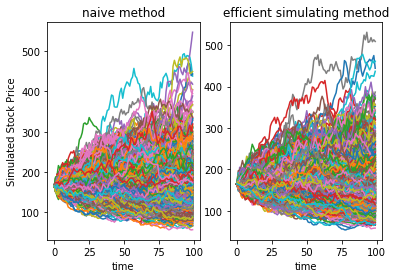

<Figure size 1080x720 with 0 Axes>

In [14]:
plt.subplot(1,2,1)
plt.plot(price[:,:])
plt.title('naive method')
plt.ylabel("Simulated Stock Price")
plt.xlabel("time")

plt.subplot(1,2,2)
plt.plot(pricess[:,:])
plt.title('efficient simulating method')
plt.xlabel("time")

plt.savefig("simulated stock path.jpg")
plt.show()


In [16]:
put_array = np.zeros((NumSim))

for i in np.arange(0, 1000):
    put_array[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim_array[i], NumJump, jump_alpha, jump_sigma, rf, 
                               strike, Call = False, stratified=False)

In [17]:
putss_array = np.zeros((NumSim))

for i in np.arange(0, 1000):
    putss_array[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim_array[i], NumJump, jump_alpha, jump_sigma, rf, 
                                      strike, Call = False, stratified=True)

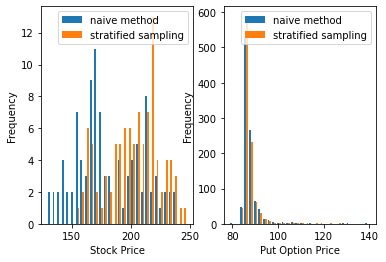

In [32]:
plt.subplot(1,2,1)
plt.hist([price[:,3], pricess[:,3]],30, label = ["naive method", "stratified sampling"])
plt.legend(loc=0)
plt.xlabel("Stock Price")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist([put_array, putss_array],30, label = ["naive method", "stratified sampling"])
plt.legend(loc=0)
plt.xlabel("Put Option Price")
plt.ylabel("Frequency")
plt.savefig("histogram of two method.jpg")
plt.show()

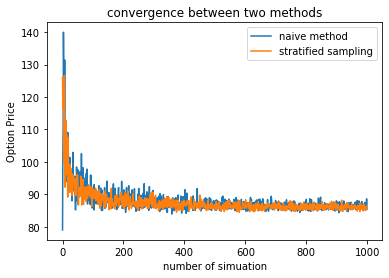

In [34]:
plt.plot(np.arange(0, 1000), put_array, putss_array)
plt.title("convergence between two methods")
plt.legend(["naive method", "stratified sampling"])
plt.ylabel("Option Price")
plt.xlabel("number of simuation")
plt.savefig("comvergence comparison.jpg")
plt.show()

### Acutal Pricing

choosing LULU, DIS, SBUX, WFC, and AAPL as underlying assets

#### LULU

In [93]:
Ticker = "lulu"
start = "2018-04-19"
end = "2023-04-19"

alpha = 0.05068

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [94]:
print("Stock Information:")
print("current price: ", spot_price)
print("alpha: ", alpha)
print("sigma: ", vol)
print("----------------------------")
print("Jump Information:")
print("number of jumps per year: ", NumJump)
print("alphaJ:", jump_alpha)
print("sigmaJ", jump_sigma)

Stock Information:
current price:  372.5
alpha:  0.05068
sigma:  0.4174144914741755
----------------------------
Jump Information:
number of jumps per year:  3.797918948521358
alphaJ: 0.0001524066255113931
sigmaJ 0.12321749263214639


##### LULU's call option

In [95]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = True)

In [96]:
call_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    call_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = True, stratified=True)

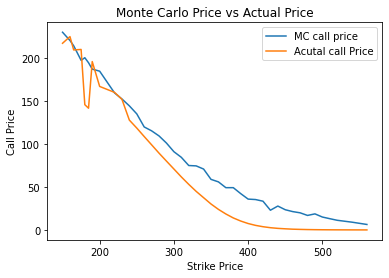

In [97]:
plt.plot(strike, call_price, label = "MC call price")
plt.plot(strike, trade_price, label = "Acutal call Price")
plt.legend()
plt.ylabel("Call Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.savefig("Lulu's Call.jpg")
plt.show()

#### LULU's put

In [98]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = False)

In [99]:
put_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    put_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = False, stratified=True)

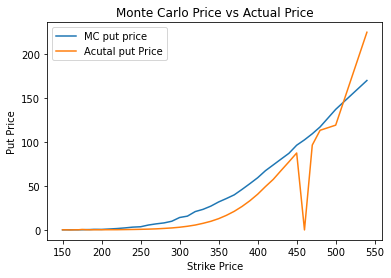

In [101]:
plt.plot(strike, put_price, label = "MC put price")
plt.plot(strike, trade_price, label = "Acutal put Price")
plt.legend()
plt.ylabel("Put Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.savefig("Lulu's Put.jpg")
plt.show()

#### DIS

In [102]:
Ticker = "dis"
start = "2018-04-19"
end = "2023-04-19"

alpha = 0.05068

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [103]:
print("Stock Information is below:")
print("current price: ", spot_price)
print("alpha: ", alpha)
print("sigma: ", vol)
print("----------------------------")
print("Jump Information is below:")
print("number of jumps per year: ", NumJump)
print("alphaJ:", jump_alpha)
print("sigmaJ", jump_sigma)

Stock Information is below:
current price:  100.93000030517578
alpha:  0.05068
sigma:  0.3276628483961232
----------------------------
Jump Information is below:
number of jumps per year:  3.797918948521358
alphaJ: 0.004225304032079992
sigmaJ 0.0990008804817177


##### DIS's call option

In [104]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = True)

In [105]:
call_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    call_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = True, stratified=True)

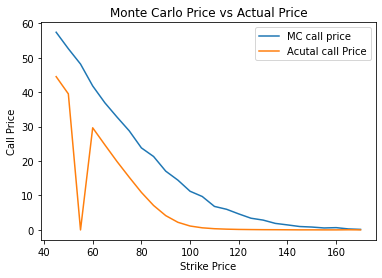

In [106]:
plt.plot(strike, call_price, label = "MC call price")
plt.plot(strike, trade_price, label = "Acutal call Price")
plt.legend()
plt.ylabel("Call Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

##### DIS's put price

In [107]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = False)

In [108]:
put_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    put_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = False, stratified=True)

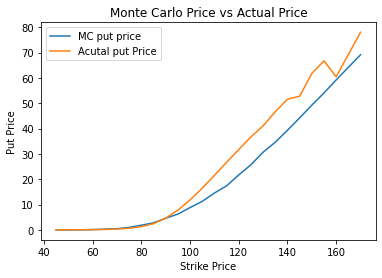

In [109]:
plt.plot(strike, put_price, label = "MC put price")
plt.plot(strike, trade_price, label = "Acutal put Price")
plt.legend()
plt.ylabel("Put Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

#### SBUX

In [110]:
Ticker = "sbux"
start = "2018-04-19"
end = "2023-04-19"

alpha = 0.05068

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [111]:
print("Stock Information is below:")
print("current price: ", spot_price)
print("alpha: ", alpha)
print("sigma: ", vol)
print("----------------------------")
print("Jump Information is below:")
print("number of jumps per year: ", NumJump)
print("alphaJ:", jump_alpha)
print("sigmaJ", jump_sigma)

Stock Information is below:
current price:  107.37535095214844
alpha:  0.05068
sigma:  0.3088565719123248
----------------------------
Jump Information is below:
number of jumps per year:  3.9978094194961664
alphaJ: 0.008401226287060222
sigmaJ 0.09246765788522389


##### SUBX's capp option

In [112]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = True)

In [113]:
call_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    call_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = True, stratified=True)

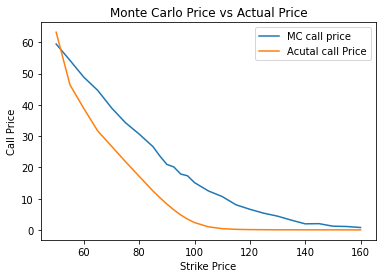

In [114]:
plt.plot(strike, call_price, label = "MC call price")
plt.plot(strike, trade_price, label = "Acutal call Price")
plt.legend()
plt.ylabel("Call Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

##### SUBX's put option

In [115]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = False)

In [116]:
put_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    put_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = False, stratified=True)

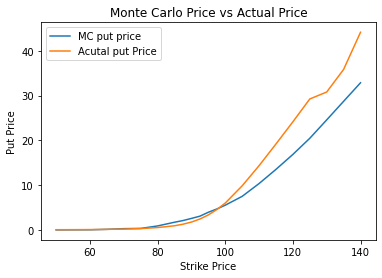

In [117]:
plt.plot(strike, put_price, label = "MC put price")
plt.plot(strike, trade_price, label = "Acutal put Price")
plt.legend()
plt.ylabel("Put Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

#### WFC

In [118]:
Ticker = "wfc"
start = "2018-04-19"
end = "2023-04-19"

alpha = 0.05068

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [119]:
print("Stock Information is below:")
print("current price: ", spot_price)
print("alpha: ", alpha)
print("sigma: ", vol)
print("----------------------------")
print("Jump Information is below:")
print("number of jumps per year: ", NumJump)
print("alphaJ:", jump_alpha)
print("sigmaJ", jump_sigma)

Stock Information is below:
current price:  41.545005798339844
alpha:  0.05068
sigma:  0.3766312050403239
----------------------------
Jump Information is below:
number of jumps per year:  4.197699890470974
alphaJ: 0.00040067934168503777
sigmaJ 0.10387427664833458


##### WFC's call option

In [120]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = True)

In [121]:
call_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    call_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = True, stratified=True)

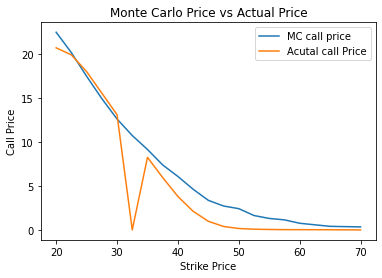

In [122]:
plt.plot(strike, call_price, label = "MC call price")
plt.plot(strike, trade_price, label = "Acutal call Price")
plt.legend()
plt.ylabel("Call Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

##### WFC's put option

In [123]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = False)

In [124]:
put_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    put_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = False, stratified=True)

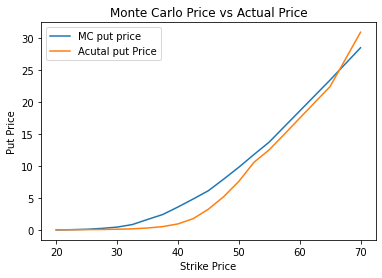

In [125]:
plt.plot(strike, put_price, label = "MC put price")
plt.plot(strike, trade_price, label = "Acutal put Price")
plt.legend()
plt.ylabel("Put Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

#### AAPL

In [126]:
Ticker = "aapl"
start = "2018-04-19"
end = "2023-04-19"

alpha = 0.05068

spot_price, vol = stock_inputs(Ticker, start, end)
NumJump, jump_alpha, jump_sigma = jump_inputs(Ticker, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [127]:
print("Stock Information is below:")
print("current price: ", spot_price)
print("alpha: ", alpha)
print("sigma: ", vol)
print("----------------------------")
print("Jump Information is below:")
print("number of jumps per year: ", NumJump)
print("alphaJ:", jump_alpha)
print("sigmaJ", jump_sigma)

Stock Information is below:
current price:  166.2400665283203
alpha:  0.05068
sigma:  0.33393690240262885
----------------------------
Jump Information is below:
number of jumps per year:  3.9978094194961664
alphaJ: 0.006313053803098693
sigmaJ 0.08657664797069264


##### AAPL's call option

In [128]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = True)

In [129]:
call_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    call_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = True, stratified=True)

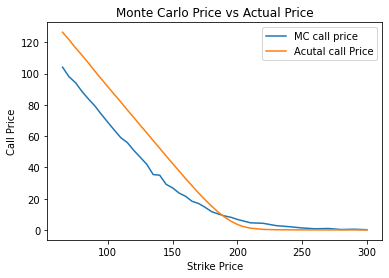

In [130]:
plt.plot(strike, call_price, label = "MC call price")
plt.plot(strike, trade_price, label = "Acutal call Price")
plt.legend()
plt.ylabel("Call Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()

##### AAPL's put option

In [131]:
dividend_rate = 0
time_to_matruity = 5/12
timesetps = 100
NumSim = 1000
rf = 0.05068

ttm = "2023-09-15"
strike, trade_price = option_info(Ticker, ttm, call = False)

In [132]:
put_price = np.zeros((len(strike)))

for i in np.arange(len(strike)):
    put_price[i] = OptionValue(spot_price, vol, dividend_rate, alpha, time_to_matruity, 
                   timesetps, NumSim, NumJump, jump_alpha, jump_sigma, rf, 
                                      strike[i], Call = False, stratified=True)

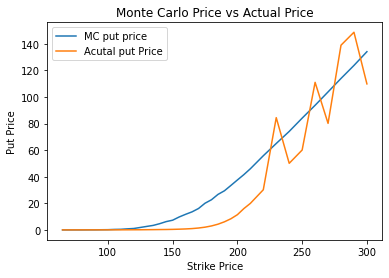

In [133]:
plt.plot(strike, put_price, label = "MC put price")
plt.plot(strike, trade_price, label = "Acutal put Price")
plt.legend()
plt.ylabel("Put Price")
plt.xlabel("Strike Price")
plt.title("Monte Carlo Price vs Actual Price")
plt.show()